# 6. Decision Trees and Ensemble Learning

In this section, we'll talk about decision trees and tree-based ensemble algorithms.

## 6.1 Credit Risk Scoring Project

In the project we'll use credit risk scoring data to make predictions whether the client is eligible for bank load or not. The dataset can be found from this [link](https://github.com/gastonstat/CreditScoring).

Below are the description of the columns in the dataset:

- `Status`: credit status
- `Seniority`: job seniority (years)
- `Home`: type of home ownership
- `Time`: time of requested load
- `Age`: client's age
- `Marital`: marital status
- `Records`: existance of records
- `Job`: type of job
- `Expenses`: amount of expenses
- `Income`: amount of income
- `Assets`: amount of assets
- `Debt`: amount of debt
- `Amount`: amount requested of loan
- `Price`: price of good

To begin, we need to import required libraries for the project:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 6.2 Data Cleaning and Preparation

- Download the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [2]:
# Dataset url
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

# Download the data
if not os.path.isfile('CreditScoring.csv'):
    !wget $data

In [3]:
# Read the data in dataframe
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# Check the number of rows and columns
df.shape

(4455, 14)

The dataset has 4455 rows and 14 columns but the column names are not in lowercase, we need to deal with it:

In [5]:
# Convert columns to lowercase
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Next thing is to check the data types of these columns.

In [6]:
# Check the columns data type
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

We see there is inconsitancey in the data types. For example, columns like `status`, `home`, `marital`, `records`, and `job` are categorical but they are stored as integer. We want to convert them into right data type.

For this purpose, we'll create a list of categorical columns and loop over them to find their unique values:

In [7]:
# List of categorical columns
categorical_cols = ['status', 'home', 'marital', 'records', 'job']

# Check unique values in each of the column
for c in categorical_cols:
    display(df[c].value_counts())

1    3200
2    1254
0       1
Name: status, dtype: int64

2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: home, dtype: int64

2    3241
1     978
4     130
3      67
5      38
0       1
Name: marital, dtype: int64

1    3682
2     773
Name: records, dtype: int64

1    2806
3    1024
2     452
4     171
0       2
Name: job, dtype: int64

Some the columns above have `0` values which will set as unknown, for rest of the values we'll replace them with appropiate values using pandas [map()](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) method:

In [8]:
# Map dict for 'status'
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [9]:
# Check uniqe values of 'status' after reformatting
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [10]:
# Implement reformatting on rest of the categorical columns
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [11]:
# View the dataframe
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


The columns are correctly formatted, now let's see the summary statistics of the numerical columns.

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


There is unsual maximum value for `income`, `assets`, and `debt`. We'll replace these values to `NaNs`.

In [13]:
# Replace '99999999' value with 'NaNs'
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

Since we have replace the above values with NaNs, we'll have to take one more step to fill these missing values with `0` so that we can use the data for model.

In [14]:
# Fill missing values with 0
df = df.fillna(0)

In [15]:
# Check the summary statistic again
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,130.0,5346.0,342.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,87.0,11525.0,1244.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,119.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,164.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


The maximum values are changed to the reasonable range. Next, we'll deal with the categorical values one more time. Our target column `status` has three categories `ok`, `default`, and `unk` but we are only intrested to know which in the clients that have the status either ok or default. Therefore, we'll extract the only those rows in the `status` column where we have the values.

In [16]:
# Extract rows of the 'status' column where the value is not 'unk'
df = df[df.status != 'unk'].reset_index(drop=True) # reset index
df.shape

(4454, 14)

Next, we'll split the data into 60% train, 20% validation, and 20% test sets with the random state of 11.

In [17]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [18]:
# Reset the index of train/val/test
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
# Convert target variable 'status' from categorical to binary for train/val/test
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [20]:
# Drop 'status' column from train/val/test
del df_train['status']
del df_val['status']
del df_test['status']

In [21]:
# Varify the split
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(2672, 891, 891)

In [22]:
df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

4454

In [23]:
y_train.shape, y_val.shape, y_test.shape

((2672,), (891,), (891,))

## 6.3 Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In simple words, decision trees make predictions based on the bunch of *if/else* statements. It starts at a single node and then splits in to two or more branches.

To replicate how decision tree works, let's create a function `assess_risk()` that takes a client as the parameter and defines tree based rules accordingly:

In [24]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

Now, let's extract a client from the train dataframe. As we have learnt in the previous sessions that our model will be getting requests in the json/dict format. Therefore, we need convert the pandas series to dictionary.

In [25]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [26]:
# Make prediction using 'assess_risk()' function
assess_risk(xi)

'ok'

Since the client has no records and the assets are more than 6000, the model reponse is ok.

Let's implement this phenomenon on train data and make predictions on validation set using sklearn `DecisionTreeClassifier`. We'll also need to import other classes and methods from sklearn library:

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [28]:
# Convert train dataframe to dictionary
train_dicts = df_train.to_dict(orient='records')
# Instantiate DictVectorizer
dv = DictVectorizer(sparse=False)
# Apply 'dv' to fit and transfrom train data to input X features
X_train = dv.fit_transform(train_dicts)

# Create the decision tree model
dt = DecisionTreeClassifier()
# Train the model
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Our model is trained, next we need to make predictions and evaluate the model on validation set.

In [29]:
# Convert val dataframe to dict
val_dicts = df_val.to_dict(orient='records')
# Apply 'dv' to transform val data to X features
X_val = dv.transform(val_dicts)

# Make predictions on val data
y_pred = dt.predict_proba(X_val)[:, 1]
# Calculate model AUC score on y_val
roc_auc_score(y_val, y_pred)

0.6532476810927321

The model is not performing well on the unseen data. Let's find out the AUC on train data.

In [30]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Our model performs very well for training data but has poor performance with validation data (unseen data). This is known as overfitting. One of the reasons our model is overfitting cause of it's depth which is increasing the complexity of the model and it is learning all the possible patterns in training data but struggle to match those patterns in the validation data.

One way to overcome this problem is by reducing the number of depth in the decision tree which can be determined using `max_depth` hyperparameter.

In [31]:
# Reduce the max depth to 2 in the model
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [32]:
# Make predictions on train and valiation data
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


Even with only two levels, we can see the slight improvement in the model performance. Let's visualize the model making these predictions:

In [33]:
# Visualize decision tree determines the rules for predictions
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



D:\repos\ml-engineering\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


From the above tree structure, we can see that when the feature `records` is **yes** (i.e., records=no <= 0.50) and if the `job seniority` is less than or equals to 6.50 years then the client ends up being *default*, but if the `job seniority` is more than 6.50 years then the client is *ok*. 

On the other hand if the client has **no** `records` (i.e., records=no > 0.50) and if the `job` is not partime, in that case the client is *ok*, but the client is *default* if the `job` is partime.

Let's create a decision tree model with only 1 maximum depth and use it to make predictions.

In [34]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.6058644740984719

We see the score has got worst than our first model.

The decision tree with single depth is called **decision stump**. It has only one split.

## 6.4 Decision Tree Learning Algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

Let's see how the decision trees come up the rules to make predictions. For that, we'll find the best split with one column on a simple dataset below:

In [35]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Based on the numerical column `assets`, we want to predict the values in the `status`. We want to try different thresholds to split the dataframe `df_example`. For example, if the condition is true in the assets, we'll have `df_right` but when the condition is false it will become `df_left`. 

The first step is to sort the values of assets to find the number of splits in the dataframe.

In [36]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


From the column `assets`, we can have six potential thresholds, let's make a list of them.

In [37]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

Notice that we don't include the max value `9000` in our thresholds list, this is where the split stops and we don't have any value on the right side of the tree.

Let's see how the our split looks like at threshold 4000.

In [38]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
display(df_right)

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


For column `assets`, the split condition is when the value is above threshold then it'll be `ok` (right side of the tree) and if the value is equal or below to the threshold then it'll end up `default` (left side of the tree).

To see how good our threshold is in terms of splitting the data, we need to calculate its misclassification rate. Classification rate tells us the percentage of incorrect predictions out of total number of predictions.

So at threshold 4000, the misclassification rate is:

- For default:
    - 3 default and 1 ok out of 4 total predictions = 1/4 = 25%
- For ok:
    3 ok and 1 default out of 4 total predictions = 1/4 = 25%
    
We need use pandas `value_counts(normalize=True)` method on `status` to find out the fraction of correct and incorrect predictions. Let's see how we can apply this:

In [39]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


Now let's see all the different classification error rates of `status` on all the possible thresholds of `assets`.

In [40]:
for T in Ts:
    print('Threshold:', T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    
    print()

Threshold: 0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

Threshold: 2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

Threshold: 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

Threshold: 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

Threshold: 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

Threshold: 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



We need to take the total average of both left and right misclassification rates to find the best threshold for splitting. The split table for `assets` looks like this:

| T    | Decision Left | Impurity Left | Decision Right | Impurity Right | Avg Misclassification |
|------|---------------|---------------|----------------|----------------|-----|
| 0    | default       | 0%            | ok             | 43%            | 21% |
| 2000 | default       | 0%            | ok             | 33%            | 16% |
| 3000 | default       | 0%            | ok             | 20%            | 10% |
| 4000 | default       | 25%           | ok             | 25%            | 25% |
| 5000 | default       | 50%           | ok             | 50%            | 50% |
| 8000 | default       | 43%           | ok             | 0%             | 21% |

From the table above we can see the best thresholds for `assets` is 3000 where we have the least misclassification rate 10%.

Let's see how can find the best threshold when we have two columns instead:

In [41]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


We have seen the thresholds split for `assets` earlier, now let's see how the split looks like for `debt` column:

In [42]:
# Sort the values by column 'debt'
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


We have the 3 different thresholds (500, 1000, and 2000) for debt. The rule for the `debt` column is when the condition is above threshold, it will end up being `default` (right side of the tree), otherwise its `ok` (left side of the tree).

Let's make a dictionary of all features we have in the dataframe that holds their threshold values respectively.

In [43]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

Next, we'll loop over the `thresholds` dictionary to find the misclassification rates of all features (in our case, `assets` and `debt`).

In [44]:
for feature, Ts in thresholds.items():
    print('#####################')
    print('Feature:', feature)
    for T in Ts:
        print('Threshold:', T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
Feature: assets
Threshold: 0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

Threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

Threshold: 3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

Threshold: 4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

Threshold: 5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

Threshold: 8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
#####################
Feature: debt
Threshold: 500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

Threshold: 1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

Threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

#####################


Here's the average misclassification rates for both features in each threshold:

$$Column: Assets$$

| T    | Decision Left | Impurity Left | Decision Right | Impurity Right | Avg Misclassification |
|------|---------------|---------------|----------------|----------------|-----|
| 0    | default       | 0%            | ok             | 43%            | 21% |
| 2000 | default       | 0%            | ok             | 33%            | 16% |
| 3000 | default       | 0%            | ok             | 20%            | 10% |
| 4000 | default       | 25%           | ok             | 25%            | 25% |
| 5000 | default       | 50%           | ok             | 50%            | 50% |
| 8000 | default       | 43%           | ok             | 0%             | 21% |

$$Column: Debt$$

| T    | Decision Left | Impurity Left | Decision Right | Impurity Right | Avg Misclassification |
|------|---------------|---------------|----------------|----------------|-----------------------|
| 500  | ok            | 0%            | default        | 43%            | 21%                   |
| 1000 | ok            | 33%           | default        | 0%             | 16%                   |
| 2000 | ok            | 43%           | default        | 0%             | 21%                   |

From the table above we can clearly see that `debt` is not as helpful as `assets` to bring down the misclassification rate. Therefore, the feature `assets` is a good predictor with the threshold of 3000 that results the least error rate.

Depending on the number of features, that is how the decision tree determines the best thresholds.

## 6.5 Decision Tree Parameter Tuning

- Selecting `max_depth`
- Selecting `min_samples_leaf`

Decision tree has many hyperparameters but the `max_depth` and `min_samples_leaf` are the most important ones when it comes to optimizing the performance.

In the first experiement we'll find the best value for `max_depth`:

In [45]:
# List of depth size
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.756
  10 -> 0.703
  15 -> 0.660
  20 -> 0.659
None -> 0.636


From the above results, we can the best auc score of 76% when the best value of max_depth is `4`, `5`, and `6`. We consider these values for our next experiement which is to find the optimal value of `min_samples_leaf`.

To make the comparison easier, we'll stores the values in `scores` list and create dataframe from it.

In [46]:
# List to store the values of max_depth, min_samples_leaf, and auc
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [47]:
# Create dataframe
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,5,0.761283
2,4,10,0.761283
3,4,15,0.763726
4,4,20,0.760910
5,4,500,0.679842
6,4,100,0.755937
7,4,200,0.747260
8,5,1,0.766938
9,5,5,0.768173


We can use seaborn heatmap function to visualize the table for finding best parameters and auc score. For that purpose we need need pandas `pivot()` method. We'll pivot the table where:

- max_samples_leaf is the index
- max_depth is the column
- auc is the values

In [48]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.762
5                 0.761  0.768  0.760
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

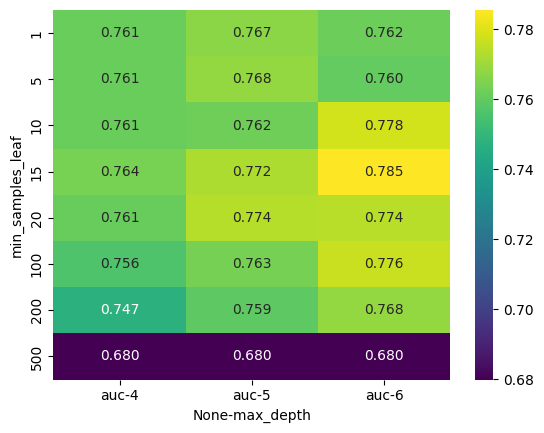

In [49]:
# Display heatmap
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f', cmap='viridis')
plt.show()

The best auc score is 78% when have `max_depth` of 6 and `min_samples_leaf` is 15.

Let's build our final model with these parameters.

In [50]:
# Train final decision tree model with best parameters value
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

We have created the model, now we want to see the text report showing the rules of our decision tree model.

In [51]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- amount <= 525.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  525.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

D:\repos\ml-engineering\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Complete information about decision trees model can be found [here](https://scikit-learn.org/stable/modules/tree.html).

## 6.6 Ensembles and Random Forest

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

Random Forest is an example of ensemble learning where each model is a decision tree and their predictions are aggregated to identify the most popular result. Random forest only select a random subset of features from the original data to make predictions. In random forest the decision trees are trained independent to each other.

Let's build our first random forest model with different number of trees (`n_estimators`), ranging from 10 to 200 with incrementation of 10. Another important parameter to set is the `random_state` for reproducibility. If we don't set the random seed than our results will change everytime we train the model because the model choses the features randomnly.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
# List to store the estimators and auc values
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    # append the values of estimators and auc scores as tuple in scores list
    scores.append((n, auc))

In [54]:
# Create a dataframe for scores list
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


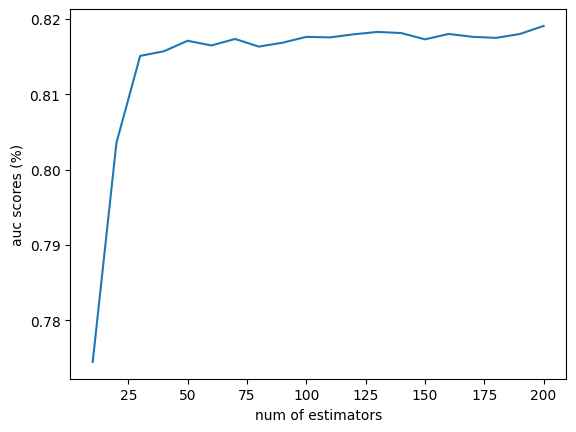

In [55]:
# Plot the 'n_estimators' vs 'auc'
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel('num of estimators')
plt.ylabel('auc scores (%)')
plt.show()

Although the accuracy is `82%` when the estimators are `200` but that is not significantly high from the estimators value at `50`, so it doesn't make sense to train with more trees than 50.

What we do next, to train model with different parameters of depth but keep the same range of estimators (i.e., 10-200).

In [56]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, n, auc))

In [57]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878
5,5,60,0.801167
6,5,70,0.802251
7,5,80,0.803244
8,5,90,0.803616
9,5,100,0.804452


Let's visualize the results for depth 5, 10, and 15 respectively.

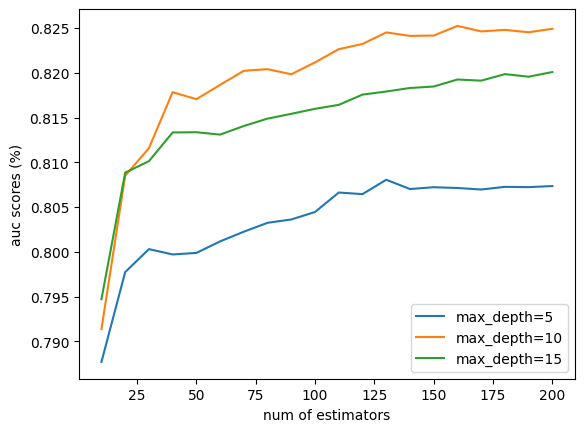

In [58]:
for d in [5, 10, 15]:
    # make subset of df_scores for each depth
    df_subset = df_scores[df_scores.max_depth == d]
    
    # plot 'estimators' and 'auc' for each depth
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label=f'max_depth={d}')
    plt.xlabel('num of estimators')
    plt.ylabel('auc scores (%)')
    plt.legend()
    
plt.show()

The AUC is kind of similar for max depth 10 and 15, but at 15 it stops growing after sometime and for 10 the accuracy is a lot better. So we'll pick max_depth of `10` as best value. On the other hand, the performance is not so good when the depth is 5.

In the next experiement, we'll find the optimal value for min_samples_leaf, with max_depth=10 and n_estimators will be same from 10-200.

In [59]:
scores = []
max_depth=10

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((s, n, auc))

In [60]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

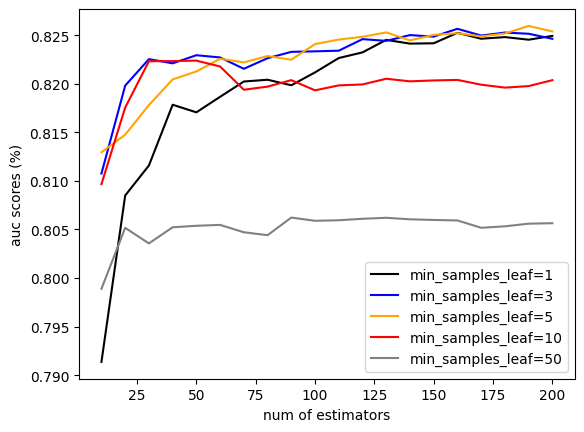

In [61]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, color in zip(values, colors):
    # make subset of df_scores for each samples leaf size
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    # plot 'estimators' and 'auc' for each samples leaf
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=color,
             label=f'min_samples_leaf={s}')
    
plt.xlabel('num of estimators')
plt.ylabel('auc scores (%)')
plt.legend()
    
plt.show()

Apart from samples leaf size of 10 (red) and 50 (grey), the AUC scores are pretty much same for other samples sizes. If we look closely the accuracy for 3 (blue) and 5 (orange) starts higher and they will probably won't make much of the difference in comparison as far as model performance is concerned.

So for our final model, we'll choose `n_estimators=100`, `max_depth=10`, and `min_samples_leaf=3`.

In [62]:
min_samples_leaf = 3

In [63]:
# Train final random forest model with best parameter values
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3)

Other useful parameters to experiment:

- `max_features`
- `bootstrap`
- `n_jobs`

We can find detailed information about random forest classifier on sklearn docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

## 6.7 Gradient Boosting and XGBoost

- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

Unlike Random Forest where each decision tree trains independently, in the Gradient Boosting Trees, the models are combined sequentially where each model takes the prediction errors made my the previous model and then tries to improve the prediction. This process continues to `n` number of iterations and in the end all the predictions get combined to make final prediction.

XGBoost is one of the libraries which implements the gradient boosting technique. To make use of the library, we need to install it and then import the library.

In [64]:
!pip install xgboost

In [65]:
import xgboost as xgb

Next, we need to wrap you train and validation data into a special data structure from xgboost and it is called `DMatrix`. This data structure is optimized to train xgboost models faster.

`DMatrix` has various parameters but the important ones are features matrix and target variables, and we can also provide feature names as well.

In [66]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(data=X_val, label=y_val, feature_names=features)

For training we can also set the `xgb_params`, which takes a dictionary of different hyperparameters. We can learn more about xgboost parameters from this [page](https://xgboost.readthedocs.io/en/stable/parameter.html).

We'll now train the model on `dtrain` data based on the default hyperparameters.

In [67]:
# Set default parameters
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6, # max depth of a tree
    'min_child_weight': 1, # min samples on leaf nodes
    'objective': 'binary:logistic', # logistic regression for binary classification task
    'nthread': 4, # num of parallel threads to run xgboost
    'seed': 1, # random seed for reproducibility
    'verbosity': 1, # verbosity of printing messages
}

# Create model with 10 interations
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

The model is trained, let's make predictions on `dval` and compute the auc score.

In [68]:
# Make predictions (returns 1D array of probability predictions)
y_pred = model.predict(dval)

# Calculate auc
roc_auc_score(y_val, y_pred)

0.8152745150274878

Just with default parameters and less iteration we are able to achieve better accuracy than our previous models.

In the next experiement, we are going to train xgboost model using same hyperparameter settings but for `200` iterations. We are also interested to observe the training performance of the model. For this purpose, we'll set `eval` parameter in the `xgb.train()` that takes a list of tuples for `xgb.DMatrix` datasets (i.e., dtrain and dval).

This list is known as `watchlist` which is use for evaluating model performance during training after each boosting iteration and stores the evaluation logs.

It is not easy to extract information from xgboost output, but we can leverage jupyter notebook magic command `%%capture output` which captures the standard out and standard err of the cell.

In [69]:
%%capture output

# Create watchlist to store model evaluation logs during training
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Set same parameters with addition of 'eval_metric'
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # set eval metric to auc
    'nthread': 4,
    'seed': 1,
    'verbosity': 1,
}

# Create model with 200 iterations and store evaluations logs after every 5 steps
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  evals=watchlist, verbose_eval=5)

Let's see the information on display.

In [70]:
# Assign the output to the variable 's'
s = output.stdout
print(s)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

The output is in the string format so we can parse the output to extract the information we need. Let's see the steps on the first log:

In [71]:
# Split the newline and white space of the first log
# it returns a list of 3 elements (num of iteration, train, and val auc)
first_log = s.split('\n')[0].split('\t')
first_log

['[0]', 'train-auc:0.86300', 'val-auc:0.76818']

In [72]:
# Unpack 'first_log' list
num_iter, train_auc, val_auc = first_log

print(num_iter)
print(train_auc)
print(val_auc)

[0]
train-auc:0.86300
val-auc:0.76818


In [73]:
# Convert 'num_iter' from string to integer
num_iter = int(num_iter.strip('[]'))

# Extract train auc score and convert to float
train_auc = float(train_auc.split(':')[1])

# Extract val auc score and convert to float
val_auc = float(val_auc.split(':')[1])

# Display results
print(num_iter)
print(train_auc)
print(val_auc)

0
0.863
0.76818


We'll create a function `parse_xgb_output()`, that will take xgboost output and perform the above steps on all the logs. We'll also store the results (num_iter, train_auc, and val_auc) in a list and create dataframe from the list.

In [74]:
def parse_xgb_output(output):
    # list to store iteration num, train and val auc
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [75]:
# Parse the output to create dataframe
df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.92863,0.80606
2,10,0.95002,0.81558
3,15,0.96558,0.81680
4,20,0.97316,0.81775
5,25,0.98174,0.81878
6,30,0.98772,0.81787
7,35,0.99180,0.81510
8,40,0.99456,0.81387
9,45,0.99596,0.81462


Let's plot the findings to make comparison:

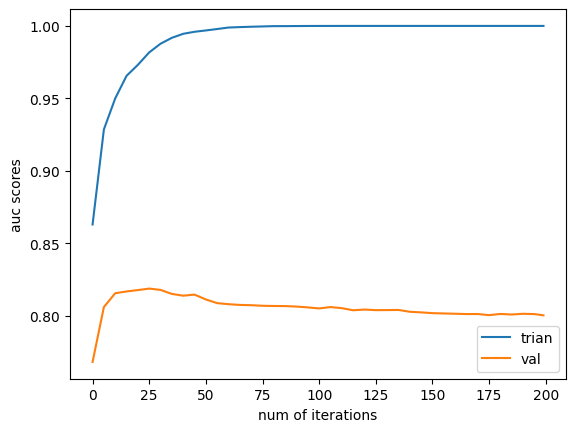

In [76]:
# Plot learning curve for training
plt.plot(df_score.num_iter, df_score.train_auc, label='trian')
# Plot learning curve for validation
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.xlabel('num of iterations')
plt.ylabel('auc scores')
plt.legend()

plt.show()

We can see the learning curve on train starts from 86% and reaches to 100% at `50th` iteration and remains stagnated. Whereas, model performance on the validation reaches to the top of 82% around at `25th` iteration but there is not significant improvement of the model after 10 iteration.

We can zoom in a little bit more on validation performance to get some more clarity about the learning curve.

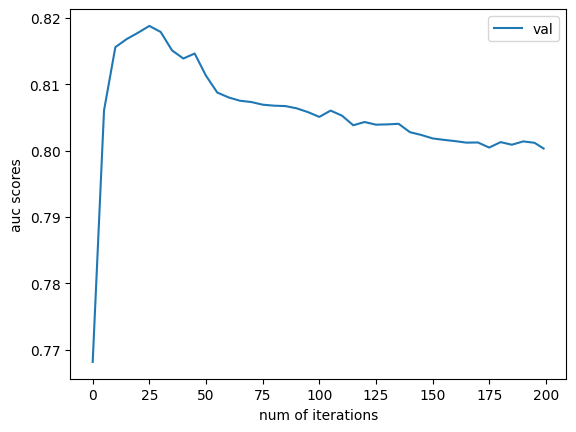

In [77]:
# Plot learning curve for validation
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.xlabel('num of iterations')
plt.ylabel('auc scores')
plt.legend()

plt.show()

## 6.8 XGBoost Parameter Tuning

Tuning the following parameters:

- `eta`
- `max_depth`
- `min_child_weight`

In our first experiment we'll try find the optimal value for `eta` and enhance the model performance. Eta is an effective way to slow down learning in the gradient boosting model. Eta is a regularization parameter that shrinks feature weights in each boosting step. For example, the default value of eta is `0.3`, that means the current model gets 30% of the weights from the previous model for correction the predictions.

We'll try the model with eta (e.g., `0.3`, `1.0`, `0.1`, `0.05`, `0.01`) and store the information of all models in the `scores` dictionary, Where the key is eta and the value is the output of the xgboost (i.e., num_iter, train_auc, and val_auc).

In [78]:
# Dict to stores eta as key and model output as value
scores = {}

In [87]:
%%capture output

# Rerun the cell until all the above eta values have been implemented
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, evals=watchlist)

In [88]:
# Extract the value of each eta from 'xgb_params'
key = f"eta={xgb_params['eta']}"

# Store the information in the 'scores' dictionary
scores[key] = parse_xgb_output(output)

In [89]:
# Learning rates in the scores dict
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

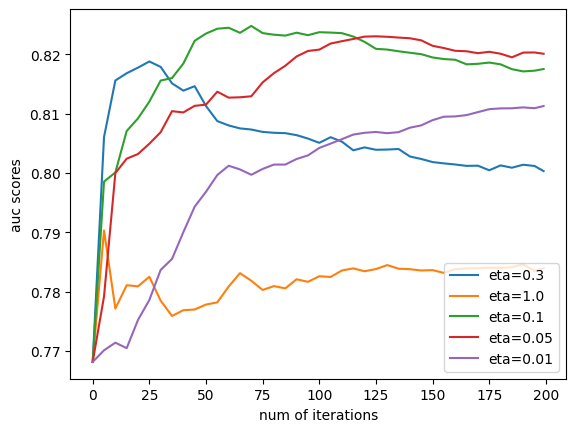

In [90]:
# Plot all eta values against each other to find the best one
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.xlabel('num of iterations')
plt.ylabel('auc scores')
plt.legend()

plt.show()

Let's go through these eta values one after another:

- `eta=0.3` (blue)
    - the accuracy gets better right from the start and reaches upto 82% percent at 25th interation but then the accuracy goes down.
- `eta=1.0` (orange)
    - this learning rate is the worst one amongst all, the accuracy reaches to 79% initally but after that it keeps dropping.
- `eta=0.1` (green)
    - this eta value is one of the optimal ones, in which the accuracy gets to the 83% after ~60 iterations. However, the accuracy gradually goes down after 125 interations.
- `eta=0.05` (red)
    - this is another best performant learning rate, but although the model accuracy surpasses when the eta=0.1, it takes around 200 iteration to reach there. Important thing to note here that model still has the highest accuracy when eta is 0.1.
- `0.01` (purple)
    - the model is improving with each iteration but it is too slow. The model may need a lot more iterations to the best accuracy score, which often times is not ideal.
    
Because the model gets to the best accuracy `83%` with fewer iterations `60%` when the eta is set to `0.1`, therefore, we'll choose this value.

Now we'll implement the same steps but for new experiements, and that'll be find best value for `max_depth`. The values we'll try for max_depth are `6`, `3`, `4`, `10`.

In [91]:
scores = {}

In [98]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, evals=watchlist)

In [99]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

In [100]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10'])

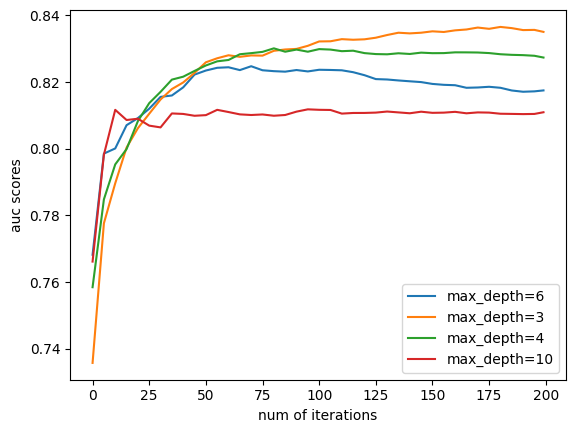

In [101]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.xlabel('num of iterations')
plt.ylabel('auc scores')
plt.legend()

plt.show()

We see the model has the worst accuracy at depth size of 10, whereas for other values, there is not much of the difference. We can remove the depth size of 10 from `scores` and plot the graph again with limits on the y-axis, that should give us more clarity to analyse the experiements.

In [102]:
del scores['max_depth=10']

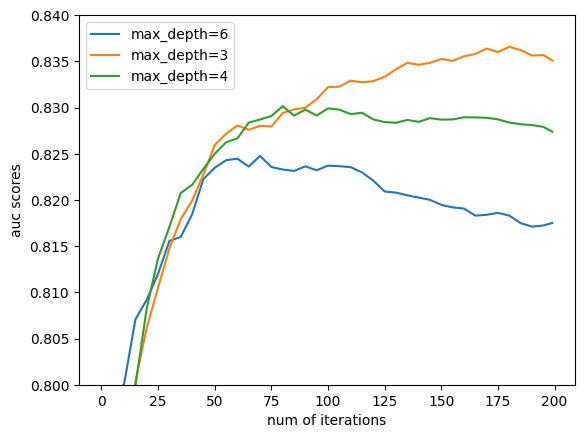

In [103]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.xlabel('num of iterations')
plt.ylabel('auc scores')
plt.ylim(0.8, 0.84)
plt.legend()

plt.show()

The max depth at `6` is the worst and at `4` the accuracy gets to 83% on 75 iterations but after that it is like of same through out the training. Whereas, the max depth at `3` has the highest accuracy, although the improvement is slow after each iteration and that's because it has the smaller tree size than others but the model is able to achieve better score than max size 6 and 4.

Our last experiments will be finding the right value for `min_child_weight` (i.e., min_samples_leaf for random forest). We'll run these experiments on `1`, `10`, and `30` values.

In [104]:
scores = {}

In [109]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, evals=watchlist)

In [110]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

In [111]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

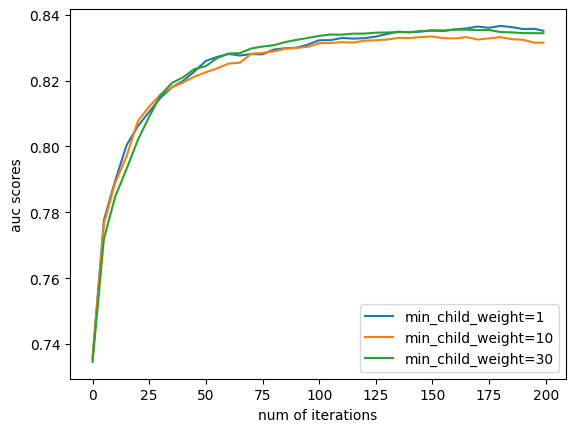

In [112]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.xlabel('num of iterations')
plt.ylabel('auc scores')
plt.legend()

plt.show()

There is no significant different here between the accuracies. Let's enlarge the graph little bit to have a closer look.

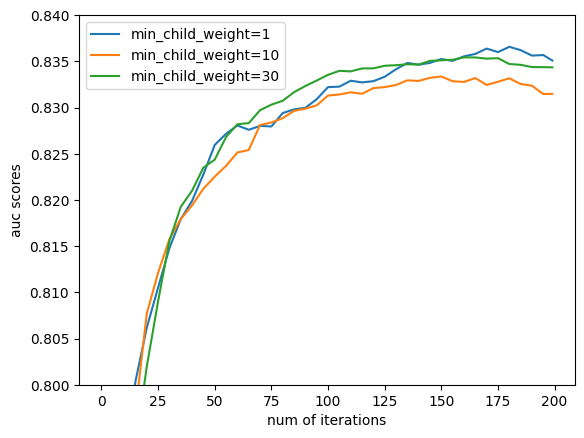

In [113]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.xlabel('num of iterations')
plt.ylabel('auc scores')
plt.ylim(0.80, 0.84)
plt.legend()

plt.show()

Here it's not worth it to experiment with this parameter, even though the accuracy is highest when min_child_weight at 1 but it is not very different to others. Therefore, we'll go for min_child_weight of `1`, simply because it is a default value.

We now have all the possible best values for our parameters, its time to build our final model using these parameters and train on `175` iterations because that's where we have got the best accuracy.

In [114]:
# Set hyperparameter values of 'eta=0.1', 'max_depth=3', and 'min_child_weight=1'
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 1,
    'verbosity': 1
}

# Build the model and train for 175 iterations
model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters to explore:
https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

- `subsample` and `colsample_bytree`
- `lambda` and `alpha`

## 6.9 Selecting the Final Model

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

We have the final models of decision tree, random forest, and xgboost. Let's train them one last time and compare the AUC scores to see which model si the best for training on the full data.

In [115]:
# Train and make predictions using our final decision tree model
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7852498123077667

In [116]:
# Train and make predictions using final random forest
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            min_samples_leaf=3)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8230758518805552

In [117]:
# Train and make predictions using final xgboost
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

Among all models, xgboost has the highest AUC scores. Therefore, we'll choose this xgboost and train it on `df_full_train` and then evaluate it on test data.

First we need to prepare data for model training.

In [118]:
# Reset index
df_full_train = df_full_train.reset_index(drop=True)
df_full_train.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,default,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,ok,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,ok,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750


In [119]:
# Convert target variable 'status' to binary integers
y_full_train = (df_full_train.status == 'default').astype(int).values

In [120]:
# Delete target variable 'status' from 'df_full_train'
del df_full_train['status']

In [121]:
# Convert 'df_full_train' dataframe to dictionary
dicts_full_train = df_full_train.to_dict(orient='records')

# Instantiate dictvectorizer
dv = DictVectorizer(sparse=False)
# Create feature matrix 'X_full_train'
X_full_train = dv.fit_transform(dicts_full_train)

# Convert 'df_test' dataframe to dictionary
dicts_test = df_test.to_dict(orient='records')
# Create feature matrix 'X_test'
X_test = dv.transform(dicts_test)

In [122]:
# Apply DMatrix wrapper on train datas
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

# Apply DMatrix on test data (without labels because we don't train model on test)
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [123]:
# Train xgboost on 'dfulltrain' for 175 iterations
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [124]:
# Make predictions and calculate auc
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8324067738624701

The model performance on the test data is good, it is able to generalize the pattern fair well on the unseen data.

Generally, xgboost models perform well on tabular data as compare to other models but the down side is that xgboost models have so tunable parameter and the reason why these models need more attention to optimize their performance.

Next, we'll save our best model to use it for the deployment. The model will be saved in `json` format using Python `pickle` library.

*Caution*: According to XGBoost [docs](https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html#loading-pickled-file-from-different-version-of-xgboost) saving XGBoost model using pickle is not recommended due to the unstability issues. However, for demonstration purpose we'll save the file with pickle.

In [127]:
import pickle

# Save the model in binary mode
with open('xgb_model.json', 'wb') as f_out:
    pickle.dump(model, f_out)

Let's reload the model and make predictions on test data to check whether it is saved properly.

In [128]:
# Load the model in binary mode
with open('xgb_model.json', 'rb') as f_in:
    load_model = pickle.load(f_in)

In [130]:
# Make predictions using 'load_model'
y_pred = load_model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8324067738624701

Both auc scores are same before and after the model is saved. Another way to make comparision is by using NumPy `all()` and see if all the predictions on `dtest` are same for both models.

In [140]:
(load_model.predict(dtest) == model.predict(dtest)).all()

True

The output `True` indicates that indeed both models are same!!

## 6.10 Summary

Following is the summary what we have gone through in this notebook:

- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.

## 6.11 Explore More

- For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
- There's a variation of random forest called "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
- XGBoost can deal with NAs - we don't have to do `fillna` for it. Check if not filling NA's help improve performance.
- Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
- When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for [random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (it's the same for plain decision trees) and for [xgboost](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
- Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.